2024-09-26 14:16:25,318 [INFO] Number of channels: 5
2024-09-26 14:16:25,319 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 302.63it/s]
2024-09-26 14:16:25,653 [INFO] Total samples in dataset: 700


Channel Data Statistics:
Channel 0: IC min=0.0, IC max=0.0089606624096632
  Step 1: min=0.0, max=0.1176629364490509
  Step 2: min=0.0, max=0.26262304186820984
  Step 3: min=0.0, max=0.5294193625450134
  Step 4: min=0.0, max=0.49203017354011536
  Step 5: min=0.0, max=0.4308709502220154
  Step 6: min=0.0, max=0.4460175931453705
  Step 7: min=0.0, max=0.44854986667633057
  Step 8: min=0.0, max=0.5955803990364075
Channel 1: IC min=0.016738668084144592, IC max=0.022297993302345276
  Step 1: min=0.016364343464374542, max=0.16503430902957916
  Step 2: min=0.016738668084144592, max=0.14859513938426971
  Step 3: min=0.013704854995012283, max=0.1770443618297577
  Step 4: min=0.013107223436236382, max=0.14893604815006256
  Step 5: min=0.002450781874358654, max=0.15798203647136688
  Step 6: min=0.012279841117560863, max=0.14854072034358978
  Step 7: min=0.01666034385561943, max=0.1524256020784378
  Step 8: min=0.013081304728984833, max=0.3029259145259857
Channel 2: IC min=0.0, IC max=1.0
  Step 1:

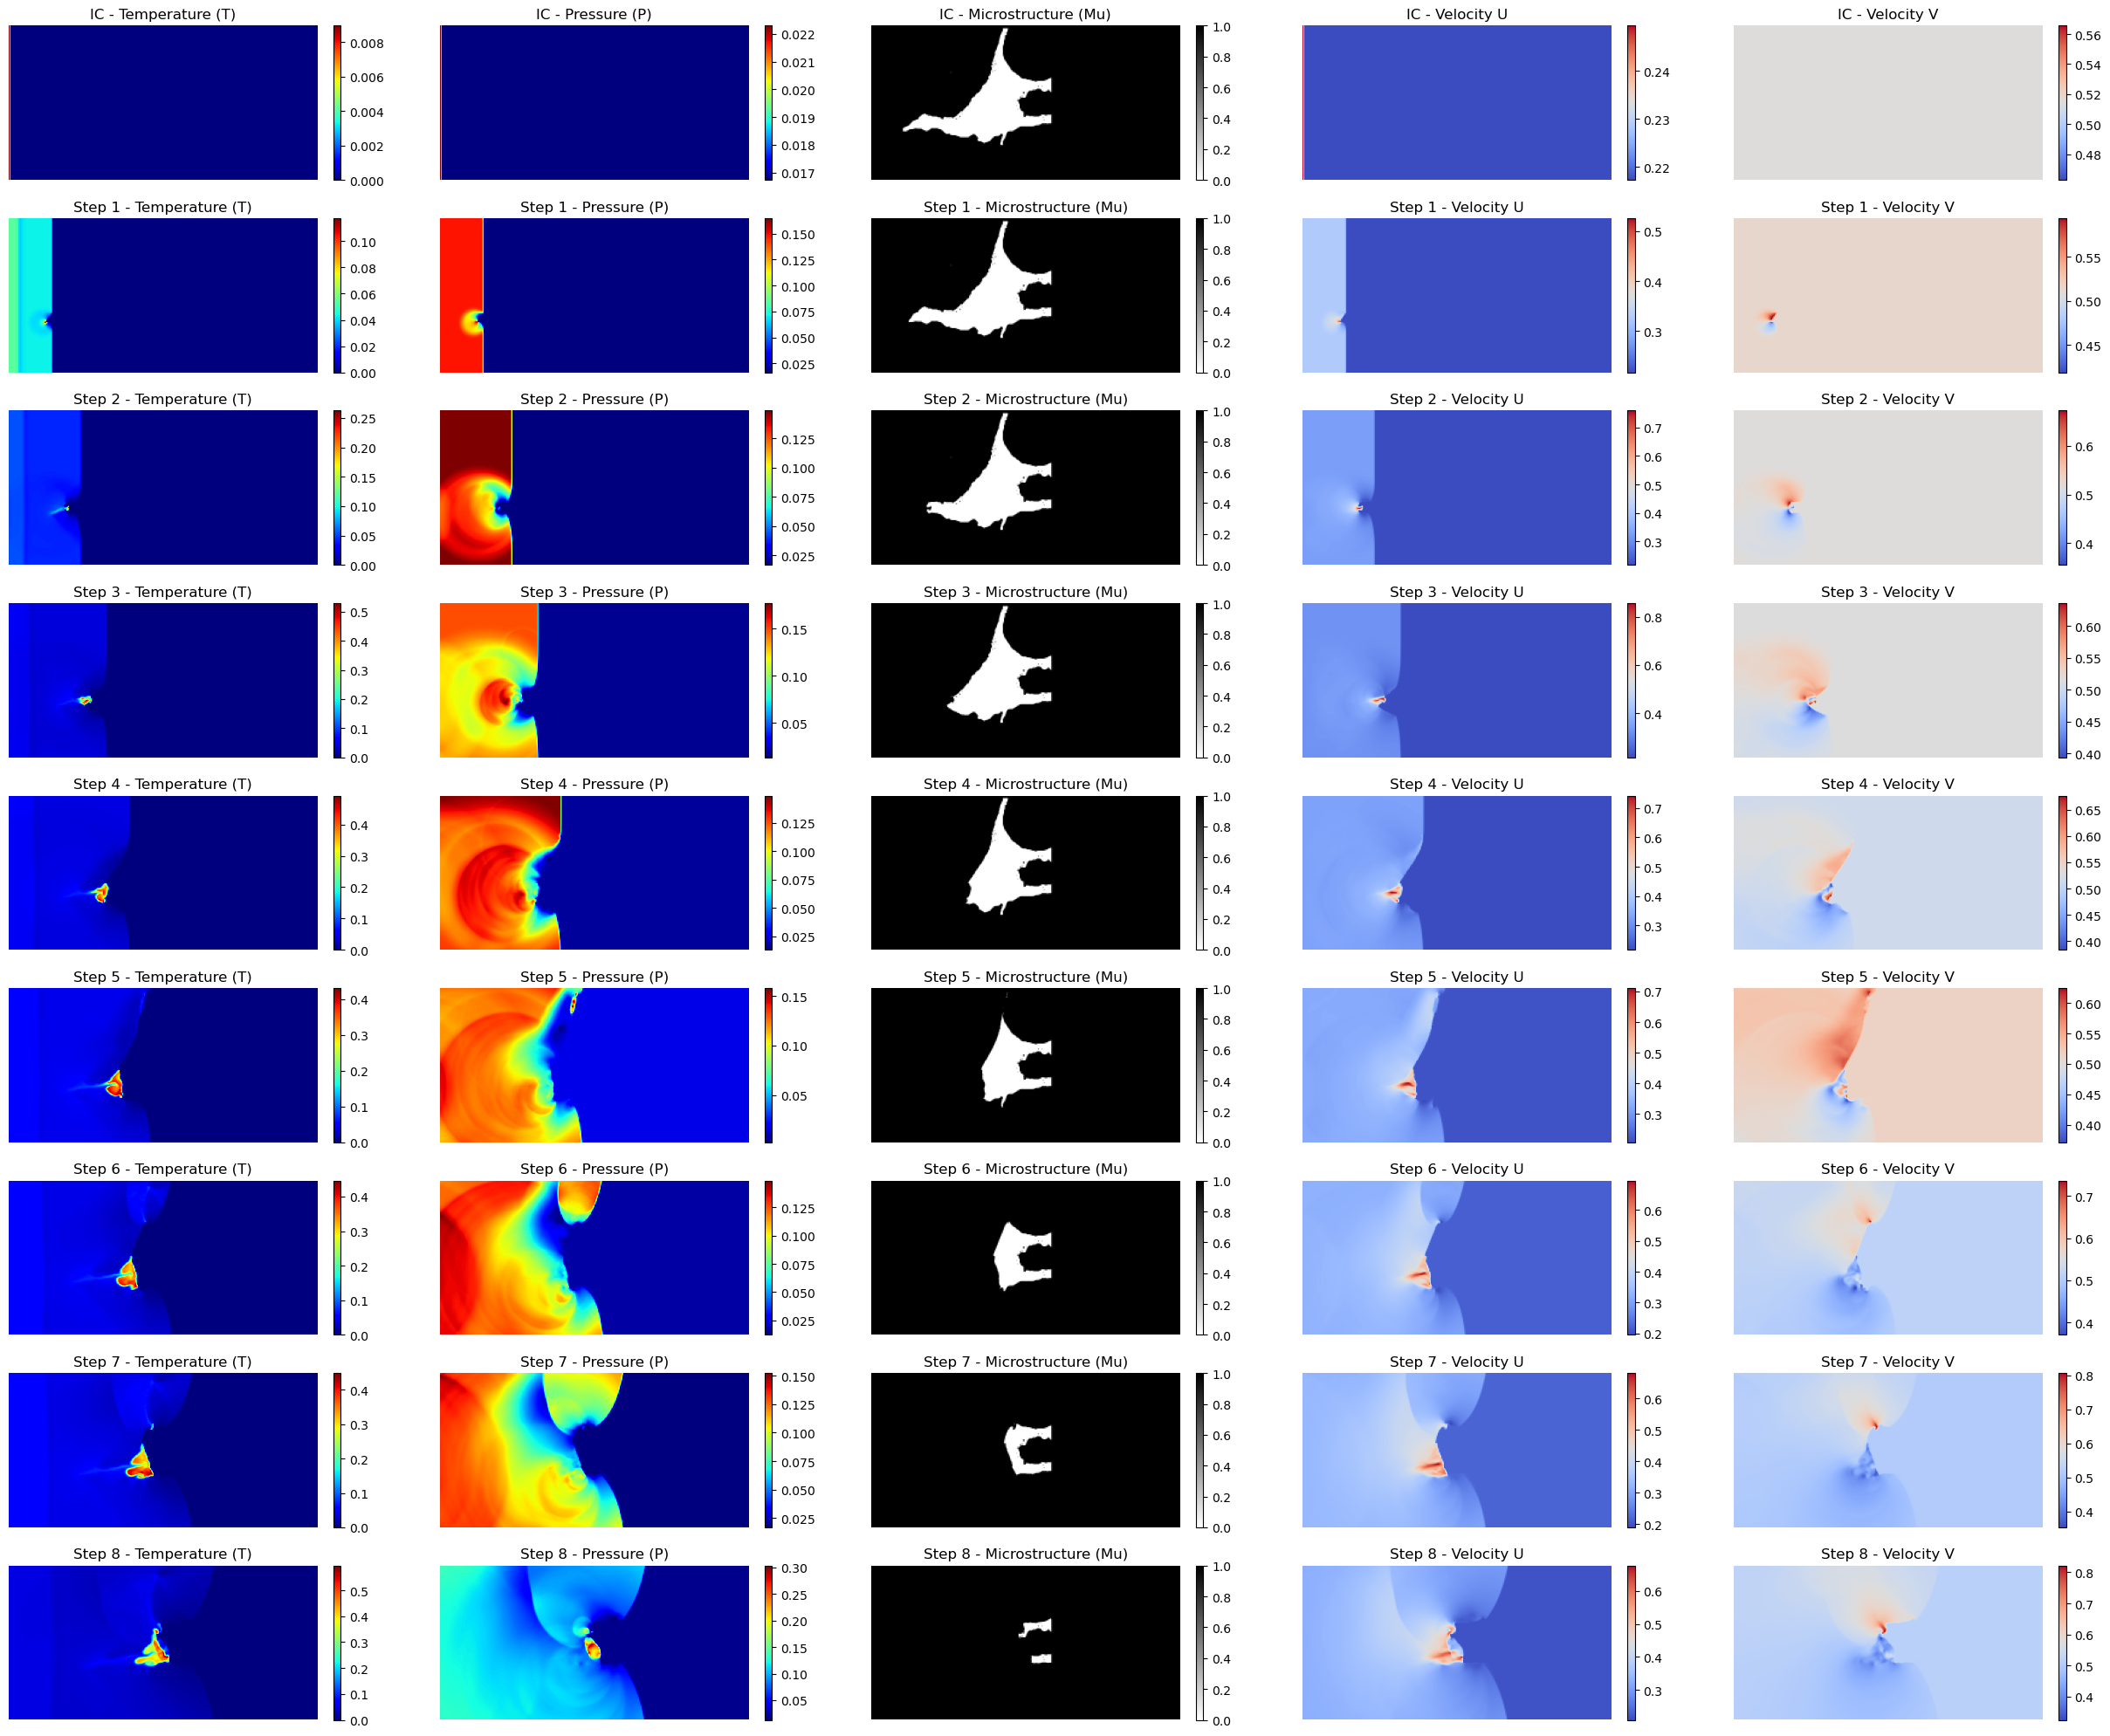

In [17]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Now import the utilities
from data.dataset import GenericPhysicsDataset, custom_collate_fn, visualize_channels

import torch
from torch.utils.data import DataLoader
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# Example configuration for HMX dataset
data_dir_train = '/project/vil_baek/data/physics/PARCTorch/HMX/train'  # Replace with your actual train directory path
data_dir_test = '/project/vil_baek/data/physics/PARCTorch/HMX/test'    # Replace with your actual test directory path
future_steps = 8
# Path to the min_max.json file
min_max_path = os.path.join('..', 'data', 'hmx_min_max.json')  # Correct path
batch_size = 8

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = ['Temperature (T)', 'Pressure (P)', 'Microstructure (Mu)', 'Velocity U', 'Velocity V']
    custom_cmaps = ['jet', 'jet', 'binary', 'coolwarm', 'coolwarm']

    visualize_channels(ic, t0, t1, target, channel_names=channel_names, channel_cmaps=custom_cmaps)
    break  # Visualize one batch for now
